In [1]:
import decoupler as dc
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
msigdb = dc.get_resource('MSigDB')
msigdb.head()

/tscc/nfs/home/pjaganna1/anaconda3/envs/decoupler/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,genesymbol,collection,geneset
0,MAFF,chemical_and_genetic_perturbations,BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN
1,MAFF,chemical_and_genetic_perturbations,ELVIDGE_HYPOXIA_UP
2,MAFF,chemical_and_genetic_perturbations,NUYTTEN_NIPP1_TARGETS_DN
3,MAFF,immunesigdb,GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN
4,MAFF,chemical_and_genetic_perturbations,SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP


In [3]:
msigdb = msigdb[msigdb['collection']=='go_biological_process'] # filter for GO Biological processes
msigdb.head()

,genesymbol,collection,geneset
33,MAFF,go_biological_process,GOBP_EMBRYO_DEVELOPMENT
44,MAFF,go_biological_process,GOBP_POSITIVE_REGULATION_OF_RNA_METABOLIC_PROCESS
82,MAFF,go_biological_process,GOBP_REGULATION_OF_EPITHELIAL_CELL_DIFFERENTIA...
94,MAFF,go_biological_process,GOBP_EMBRYO_DEVELOPMENT_ENDING_IN_BIRTH_OR_EGG...
108,MAFF,go_biological_process,GOBP_IN_UTERO_EMBRYONIC_DEVELOPMENT


In [4]:
# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

In [5]:
# Rename
msigdb.loc[:, 'geneset'] = [name.split('GOBP_')[1] for name in msigdb['geneset']]

In [6]:
genes_df = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/notebooks/231_data/annotated_gene_editsC_copy_wsig_jan2024.txt', sep='\t',index_col=0 )

In [10]:
# filtering for genes with decrease in translation after CoCl2
down_list = genes_df[(genes_df['ttest_pval']<=0.05) & (genes_df['edit_logFC'] <=-1)]['gene_name'].tolist()

In [11]:
# filtering for genes with increase in translation after CoCl2
up_list = genes_df[(genes_df['ttest_pval']<=0.05) & (genes_df['edit_logFC'] >=1)]['gene_name'].tolist()

In [12]:
up = pd.DataFrame(up_list)

In [13]:
down = pd.DataFrame(down_list)

In [14]:
up = up.rename(columns={0: 'gene_name'})

In [15]:
down = down.rename(columns={0: 'gene_name'})

In [16]:
gene_tables = {'up': up, 'down':down}

In [17]:
go_pvals = {}
for i in gene_tables:
    top_genes = gene_tables[i].copy()
    top_genes = top_genes.set_index('gene_name')
    top_genes['group'] = 'RPS2.vs.STAMP'
    
    # Run ora
    enr_pvals = dc.get_ora_df(
        df=top_genes,
        net=msigdb,
        source='geneset',
        target='genesymbol'
    )
    
    #enr_pvals = enr_pvals[enr_pvals['FDR p-value']<=0.05]
    enr_pvals['-log10 FDR p-value'] = -np.log10(enr_pvals['FDR p-value'])
    go_pvals[i] = enr_pvals


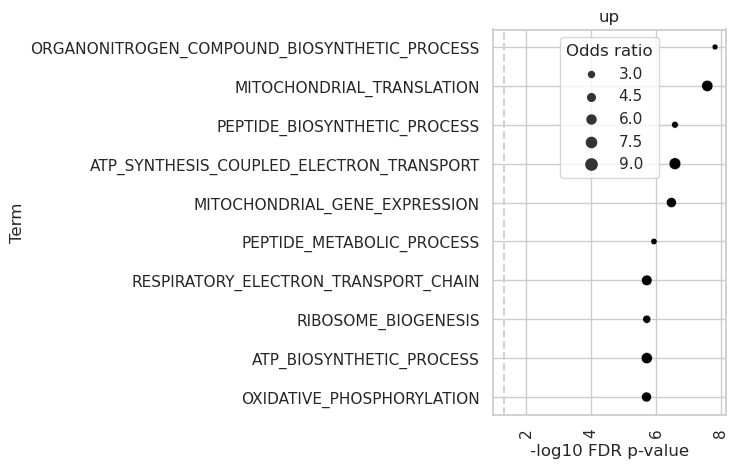

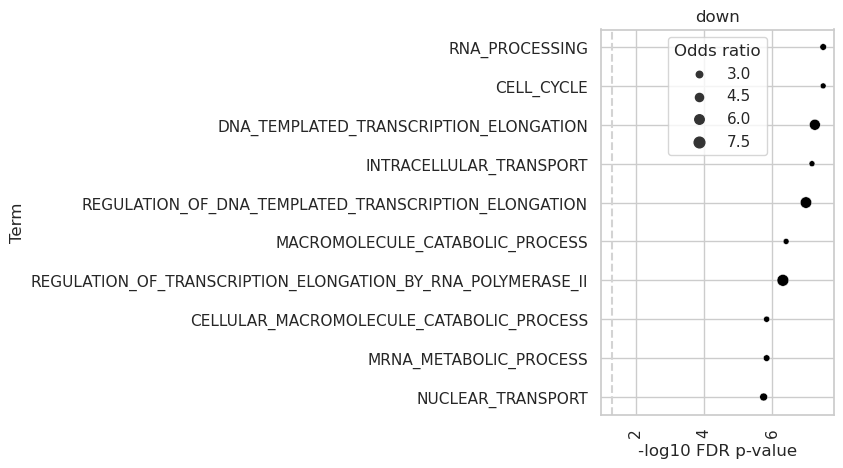

In [18]:
sns.set(rc={'figure.figsize':(3,5)})
sns.set_style('whitegrid')
for i in go_pvals:
    # go_pvals[i][['Term', '-log10 FDR p-value', 'Odds ratio']].sort_values(by='-log10 FDR p-value', ascending=False).head(10).plot.scatter(x='-log10 FDR p-value',
    #                   y='Term',
    #                   c='Odds ratio',
    #                   cmap='mako_r', fontsize=8)
    sns.scatterplot(data=go_pvals[i][['Term', '-log10 FDR p-value', 'Odds ratio']].sort_values(by='-log10 FDR p-value', ascending=False).head(10),x='-log10 FDR p-value',y='Term',size='Odds ratio', color='black')
    plt.xticks(rotation=90)
    plt.axvline(-np.log10(0.05), linestyle='dashed', color='lightgrey')
    plt.title(i)
    plt.show()